In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import import_ipynb
import os
import warnings
import Lib.Functions as fc
warnings.filterwarnings('ignore')

importing Jupyter notebook from /Users/vuhan/Desktop/LDS6_269C7N5_ON_VuTranHoaiHan_MidExam/Lib/Functions.ipynb


# Text Classification

Đầu tiên, ta viết một hàm đọc dữ liệu trong folder, hàm này sẽ nhận tên của folder và trả về một DataFrame chứa nội dung (dạng văn bản) của từng file chứa trong từng folder con. Hàm này sẽ được lưu vào thư viện __Lib__ để dành cho việc load và đánh giá dữ liệu test.

In [2]:
def load_dataset(folder_name):
    my_dir = os.getcwd() + '/' + folder_name
    folder_names = []
    folder_paths = []
    for entry_name in os.listdir(my_dir):
        entry_path = os.path.join(my_dir, entry_name)
        if os.path.isdir(entry_path):
            folder_names.append(entry_name)
            folder_paths.append(entry_path)
    data = []
    for name, path in zip(folder_names, folder_paths):
        temp_lst = []
        for filename in os.listdir(path):
            entry_file = os.path.join(path, filename)
            with open(entry_file, 'r', encoding = 'latin-1') as f:
                content = f.read().replace('\n', ' ').rstrip(' ')
                temp_lst.append(str(content))
        df = pd.DataFrame({'Text': temp_lst, 'Class': np.array([name] * len(temp_lst))})
        data.append(df)
    final_df = pd.concat(data)
    return final_df

In [3]:
folder_data = 'bbc_train'
df = load_dataset(folder_data)
df.head()

,Text,Class
0,Musicians to tackle US red tape Musicians' gr...,entertainment
1,"U2's desire to be number one U2, who have won...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,Ocean's Twelve raids box office Ocean's Twelv...,entertainment


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1854 entries, 0 to 348
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    1854 non-null   object
 1   Class   1854 non-null   object
dtypes: object(2)
memory usage: 43.5+ KB


Ta sẽ xem qua số lượng mẫu của từng lớp trong dữ liệu.

----- Class -----
Describe: 
count         1854
unique           5
top       business
freq           430
Name: Class, dtype: object
* Unique value: 
business         430
sport            427
politics         350
tech             349
entertainment    298
Name: Class, dtype: int64
* Mode value: business
* Number of missing value: 0


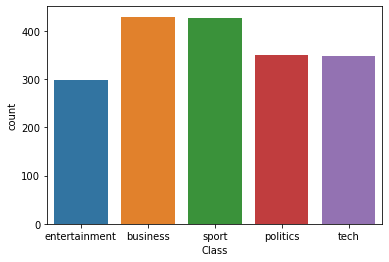

In [5]:
fc.categorical_analysis(df, 'Class')

Trước khi đi vào phân tích, ta sẽ tách dataset thành tập train và test với tỉ lệ tập test là 20% trên tổng số dòng dữ liệu:

In [6]:
from sklearn.model_selection import train_test_split, cross_val_score

X = df.iloc[:, 0]
y = df.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

Xử lý dữ liệu văn bản bằng lớp `CountVectorizer` của Sklearn và khớp với tập train, test:

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words = 'english')

X_train_cv = cv.fit_transform(X_train)
X_test_cv = cv.transform(X_test)

In [8]:
print(X_train_cv.shape, X_test_cv.shape)

(1483, 24678) (371, 24678)


Ta sẽ bắt đầu với thuật toán `MultinomialNB` của lớp `naive_bayes`: 

In [9]:
from sklearn.naive_bayes import MultinomialNB

multiNB = MultinomialNB()
multiNB.fit(X_train_cv, y_train)

MultinomialNB()

In [10]:
multiNB.score(X_train_cv, y_train)

0.9959541469993257

Độ chính xác của `MultinomialNB` trên tập train gần như tuyệt đối, ta sẽ đánh giá bằng kiểm định chéo với 5 fold mặc định và tính trung bình số điểm độ chính xác:

In [11]:
multiNB_score = cross_val_score(multiNB, X_train_cv, y_train, cv=5)
multiNB_score.mean()

0.9777345527345528

Trung bình kiểm định chéo không khác biệt quá lớn. Tiếp theo, ta sẽ đánh giá mô hình bằng tập test, đồng thời hiển thị các thông số quan trọng trong việc đánh giá bài toán phân loại như 

_confusion matrix, precision_ và _recall_ :


Hàm `eval_clf_testset` đã được viết sẵn trong thư viện Lib, hàm này trả về độ chính xác của mô hình trên tập test, ma trận nhầm lẫn, các giá trị precision, recall và f1-score của từng lớp:

In [12]:
fc.eval_clf_testset(multiNB, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9569

* Confusion Matrix of Test: 
[[89  1  4  0  2]
 [ 0 54  1  0  1]
 [ 2  0 64  0  1]
 [ 1  0  0 76  0]
 [ 1  1  1  0 72]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.96      0.93      0.94        96
entertainment       0.96      0.96      0.96        56
     politics       0.91      0.96      0.93        67
        sport       1.00      0.99      0.99        77
         tech       0.95      0.96      0.95        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Mô hình `MultinomialNB` bị overfitting nhẹ, tuy nhiên các lớp được phân loại khá ổn. Một ứng viên triển vọng cho quá trình lựa chọn.

Ta sẽ thử phân loại với một thuật toán phổ biến khác sử dụng phương pháp xác suất để phân loại các lớp,

`Logistic Regression`:

In [13]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(multi_class = 'ovr', random_state = 42)
logit.fit(X_train_cv, y_train)

LogisticRegression(multi_class='ovr', random_state=42)

In [14]:
logit.score(X_train_cv, y_train)

1.0

In [15]:
logit_score = cross_val_score(logit, X_train_cv, y_train, cv=5)
logit_score.mean()

0.9763991263991263

Độ chính xác tuyệt đối trên tập train và kiểm định chéo với số điểm gần tương đương, 

ta sẽ xem mô hình hoạt động như thế nào trên dữ liệu test:

In [16]:
fc.eval_clf_testset(logit, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.965

* Confusion Matrix of Test: 
[[92  1  1  0  2]
 [ 0 54  0  0  2]
 [ 2  1 63  0  1]
 [ 0  0  0 77  0]
 [ 3  0  0  0 72]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.95      0.96      0.95        96
entertainment       0.96      0.96      0.96        56
     politics       0.98      0.94      0.96        67
        sport       1.00      1.00      1.00        77
         tech       0.94      0.96      0.95        75

     accuracy                           0.96       371
    macro avg       0.97      0.96      0.97       371
 weighted avg       0.97      0.96      0.97       371



Độ chính xác nhỉnh hơn một chút và giảm overfitting so với `MultinomialNB`, `Logistic Regression` có vẻ khớp khá tốt với dữ liệu.

Các bộ phân loại từ đầu đến giờ đều có một điểm chung là có thể ước tính xác suất của từng lớp, bây giờ ta sẽ huấn luyện với một mô hình mạnh mẽ khác sử dụng các ranh giới để phân loại: `Support Vector Machine`.

Ta sẽ bắt đầu với `SVC`:

In [17]:
from sklearn.svm import SVC

svc_o = SVC(random_state = 42)
svc_o.fit(X_train_cv, y_train)

SVC(random_state=42)

In [19]:
svc_o.score(X_train_cv, y_train)

0.9986513823331086

In [20]:
import time

t1 = time.time()
svc_o_score = cross_val_score(svc_o, X_train_cv, y_train, cv=5, n_jobs = -1)
t2 = time.time()

print('SVC cross validation took {:.2f}s.'.format(t2 - t1))
print(svc_o_score.mean())

SVC cross validation took 3.28s.
0.9501023751023752


In [21]:
fc.eval_clf_testset(svc_o, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9461

* Confusion Matrix of Test: 
[[91  1  2  0  2]
 [ 0 54  0  0  2]
 [ 2  1 63  0  1]
 [ 1  0  0 74  2]
 [ 6  0  0  0 69]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.91      0.95      0.93        96
entertainment       0.96      0.96      0.96        56
     politics       0.97      0.94      0.95        67
        sport       1.00      0.96      0.98        77
         tech       0.91      0.92      0.91        75

     accuracy                           0.95       371
    macro avg       0.95      0.95      0.95       371
 weighted avg       0.95      0.95      0.95       371



Không tệ, tuy nhiên hơi thấp so với các mô hình phía trên. Ta sẽ tìm kiếm dạng lưới cho việc tinh chỉnh mô hình:

In [22]:
from sklearn.model_selection import GridSearchCV
import time

params_svc = [{'kernel': ['rbf', 'linear'], 
               'C': [1, 10, 100, 1000], 
               'gamma': np.linspace(0.001, 0.01, 10)}]

grid_search_svc = GridSearchCV(SVC(random_state = 42), params_svc, cv=4, n_jobs = -1)
t1 = time.time()
grid_search_svc.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search for SVC took {:.2f} minutes.'.format((t2 - t1) / 60))

Grid Search for SVC took 1.25 minutes.


In [23]:
print(grid_search_svc.best_params_)
print(grid_search_svc.best_estimator_)

{'C': 1, 'gamma': 0.001, 'kernel': 'linear'}
SVC(C=1, gamma=0.001, kernel='linear', random_state=42)


In [24]:
grid_search_svc.score(X_train_cv, y_train)

1.0

In [25]:
t1 = time.time()
svc_gr_score = cross_val_score(grid_search_svc, X_train_cv, y_train, n_jobs = -1)
t2 = time.time()

print('SVC cross validation took {:.2f}s.'.format(t2 - t1))
print(svc_gr_score.mean())

SVC cross validation took 278.35s.
0.9662890162890163


In [26]:
fc.eval_clf_testset(grid_search_svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9569

* Confusion Matrix of Test: 
[[90  3  1  0  2]
 [ 0 55  0  0  1]
 [ 2  1 63  0  1]
 [ 0  0  0 77  0]
 [ 4  0  1  0 70]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.94      0.94      0.94        96
entertainment       0.93      0.98      0.96        56
     politics       0.97      0.94      0.95        67
        sport       1.00      1.00      1.00        77
         tech       0.95      0.93      0.94        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Tìm kiếm dạng lưới cho thấy mô hình `SVC`với hạt nhân tuyến tính có vẻ khớp tốt hơn và cho kết quả khả quan hơn so với các hạt nhân khác.

Ta sẽ thử thêm một mô hình SVM khác cho tác vụ phân loại, lần này là `LinearSVC`, ta cũng sẽ bắt đầu với các tham số mặc định: 

In [27]:
from sklearn.svm import LinearSVC

lin_svc = LinearSVC(random_state = 42)
lin_svc.fit(X_train_cv, y_train)

LinearSVC(random_state=42)

In [28]:
lin_svc.score(X_train_cv, y_train)

1.0

In [29]:
lin_svc_score = cross_val_score(lin_svc, X_train_cv, y_train, cv=5)
lin_svc_score.mean()

0.9757257257257258

In [30]:
fc.eval_clf_testset(lin_svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9569

* Confusion Matrix of Test: 
[[88  2  4  0  2]
 [ 0 55  0  0  1]
 [ 2  1 63  0  1]
 [ 0  0  0 77  0]
 [ 3  0  0  0 72]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.95      0.92      0.93        96
entertainment       0.95      0.98      0.96        56
     politics       0.94      0.94      0.94        67
        sport       1.00      1.00      1.00        77
         tech       0.95      0.96      0.95        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Ta sẽ thử tìm kiếm dạng lưới với mô hình này với hy vọng sẽ cải thiện được các điểm số đánh giá mà ta quan tâm:

In [31]:
params_lin_svc = [{'loss': ['hinge', 'squared-hinge'], 
                   'C': [1, 10, 100, 1000], 
                   'max_iter': [1000, 5000, 10000],
                   'dual': [True, False]}]

grid_search_lin_svc = GridSearchCV(LinearSVC(random_state = 42), 
                                   params_lin_svc, cv=4, n_jobs = -1)
t1 = time.time()
grid_search_lin_svc.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search for LinearSVC took {:.2f} minutes.'.format((t2 - t1) / 60))

Grid Search for LinearSVC took 0.08 minutes.


In [32]:
grid_search_lin_svc.best_params_

{'C': 1, 'dual': True, 'loss': 'hinge', 'max_iter': 1000}

In [33]:
grid_search_lin_svc.score(X_train_cv, y_train)

1.0

In [34]:
lin_svc_gr = cross_val_score(grid_search_lin_svc, X_train_cv, y_train, n_jobs = -1)
lin_svc_gr.mean()

0.9757257257257258

In [35]:
fc.eval_clf_testset(grid_search_lin_svc, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9569

* Confusion Matrix of Test: 
[[88  2  4  0  2]
 [ 0 55  0  0  1]
 [ 2  1 63  0  1]
 [ 0  0  0 77  0]
 [ 3  0  0  0 72]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.95      0.92      0.93        96
entertainment       0.95      0.98      0.96        56
     politics       0.94      0.94      0.94        67
        sport       1.00      1.00      1.00        77
         tech       0.95      0.96      0.95        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Kết quả tương tự như các tham số mặc định, khác biệt nhỏ ở đây là Tìm kiếm dạng lưới cho thấy hàm loss trong `LinearSVC` là __hinge__.

Các mô hình độc lập hoạt động khá tốt trên dữ liệu, bây giờ ta sẽ xem các mô hình học _ensemble_ hoạt động ra sao.

Khởi đầu với `RandomForestClassifier` và các tham số mặc định:

In [36]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(random_state = 42)
t1 = time.time()
forest.fit(X_train_cv, y_train)
t2 = time.time()

print('RandomForestClassifier training took {:.3f}s.'.format(t2 - t1))

RandomForestClassifier training took 0.638s.


In [37]:
forest.score(X_train_cv, y_train)

1.0

Độ chính xác tuyệt đối! Ta sẽ đánh giá cụ thể hơn bằng kiểm định chéo:



In [38]:
forest_score = cross_val_score(forest, X_train_cv, y_train, cv=5)
forest_score.mean()

0.9588702338702338

Không quá tệ đối với kiểm định 5 fold, ta sẽ xem mô hình hoạt động ra sao trên tập kiểm tra:

In [39]:
fc.eval_clf_testset(forest, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9488

* Confusion Matrix of Test: 
[[94  0  0  0  2]
 [ 2 52  1  0  1]
 [ 3  0 63  0  1]
 [ 1  0  0 76  0]
 [ 7  1  0  0 67]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.88      0.98      0.93        96
entertainment       0.98      0.93      0.95        56
     politics       0.98      0.94      0.96        67
        sport       1.00      0.99      0.99        77
         tech       0.94      0.89      0.92        75

     accuracy                           0.95       371
    macro avg       0.96      0.95      0.95       371
 weighted avg       0.95      0.95      0.95       371



Các điểm số đánh giá có vẻ khá thấp nếu so với các kết quả có được từ các mô hình phía trên. 

Ta sẽ dùng Tìm kiếm dạng lưới để tinh chỉnh các Siêu tham số với hy vọng mô hình sẽ hoạt động tốt hơn: 

In [40]:
from sklearn.model_selection import GridSearchCV

params_forest = {'n_estimators': [90, 120, 150],
                'bootstrap': [True, False], 
                'max_depth': [1, 3, 5, 7, None]}

grid_search_forest = GridSearchCV(RandomForestClassifier(random_state = 42), params_forest, cv=4, n_jobs = -1)
t1 = time.time()
grid_search_forest.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search RandomForestClassifier took {:.3f}s.'.format(t2 - t1))

Grid Search RandomForestClassifier took 9.070s.


In [41]:
grid_search_forest.best_params_

{'bootstrap': False, 'max_depth': None, 'n_estimators': 120}

In [42]:
fc.eval_clf_testset(grid_search_forest, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9623

* Confusion Matrix of Test: 
[[94  0  0  0  2]
 [ 2 54  0  0  0]
 [ 2  0 63  1  1]
 [ 0  0  0 77  0]
 [ 6  0  0  0 69]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.90      0.98      0.94        96
entertainment       1.00      0.96      0.98        56
     politics       1.00      0.94      0.97        67
        sport       0.99      1.00      0.99        77
         tech       0.96      0.92      0.94        75

     accuracy                           0.96       371
    macro avg       0.97      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



In [43]:
forest_gr_score = cross_val_score(grid_search_forest, X_train_cv, y_train, cv=5)
forest_gr_score.mean()

0.9662821912821913

Kết quả có vẻ khả quan hơn so với các tham số mặc định, độ chính xác và f1-score cải thiện từ 1 - 2%.

Một lựa chọn khác cho việc sử dụng Cây Quyết định trong lớp _ensemble_ của Sklearn là mô hình Cây Siêu ngẫu nhiên `ExtraTreesClassifier`

`ExtraTreesClassifier` sử dụng ngưỡng ngẫu nhiên đối với từng đặc trưng thay vì tìm kiếm các ngưỡng tốt nhất nên thời gian chạy thuật toán sẽ rút ngắn so với `Decision Tree`:

In [44]:
from sklearn.ensemble import ExtraTreesClassifier

trees = ExtraTreesClassifier(n_estimators = 120, random_state = 42)
t1 = time.time()
trees.fit(X_train_cv, y_train)
t2 = time.time()

print('ExtraTreesClassifier training took {:.3f}s.'.format(t2 - t1))

ExtraTreesClassifier training took 1.109s.


In [45]:
trees.score(X_train_cv, y_train)

1.0

In [46]:
trees_score = cross_val_score(trees, X_train_cv, y_train, cv=5)
trees_score.mean()

0.9662821912821913

In [47]:
fc.eval_clf_testset(trees, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9515

* Confusion Matrix of Test: 
[[95  0  0  0  1]
 [ 2 53  1  0  0]
 [ 6  0 60  0  1]
 [ 0  0  0 77  0]
 [ 6  1  0  0 68]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.87      0.99      0.93        96
entertainment       0.98      0.95      0.96        56
     politics       0.98      0.90      0.94        67
        sport       1.00      1.00      1.00        77
         tech       0.97      0.91      0.94        75

     accuracy                           0.95       371
    macro avg       0.96      0.95      0.95       371
 weighted avg       0.96      0.95      0.95       371



Không tệ, ta sẽ tinh chỉnh mô hình bằng Tìm kiếm dạng lưới để tìm kiếm mức hiệu suất cao hơn cho các chỉ số đánh giá:

In [48]:
params_trees = {'n_estimators': [90, 120, 300, 350],
                'bootstrap': [True, False], 
                'max_depth': [1, 3, 5, 7, None]}

grid_search_trees = GridSearchCV(ExtraTreesClassifier(random_state = 42), params_trees, cv=4, n_jobs = -1)
t1 = time.time()
grid_search_trees.fit(X_train_cv, y_train)
t2 = time.time()

print('Grid Search ExtraTreesClassifier took {:.3f}s.'.format(t2 - t1))

Grid Search ExtraTreesClassifier took 24.138s.


In [49]:
grid_search_trees.best_params_

{'bootstrap': False, 'max_depth': None, 'n_estimators': 300}

In [50]:
trees_gr_score = cross_val_score(grid_search_trees, X_train_cv, y_train, cv=5, n_jobs = -1)
trees_gr_score.mean()

0.9696560196560198

In [51]:
fc.eval_clf_testset(grid_search_trees, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9569

* Confusion Matrix of Test: 
[[95  0  0  0  1]
 [ 2 53  1  0  0]
 [ 5  0 61  0  1]
 [ 0  0  0 77  0]
 [ 5  1  0  0 69]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.89      0.99      0.94        96
entertainment       0.98      0.95      0.96        56
     politics       0.98      0.91      0.95        67
        sport       1.00      1.00      1.00        77
         tech       0.97      0.92      0.95        75

     accuracy                           0.96       371
    macro avg       0.97      0.95      0.96       371
 weighted avg       0.96      0.96      0.96       371



Điểm số của các phép đo chất lượng đều cải thiện hơn so với khi sử dụng các siêu tham số mặc định.

Hai thuật toán mạnh mẽ trong lớp _ensemble_ của Sklearn mang lại kết quả khá tốt.


Ta sẽ sử dụng thêm một phương pháp học _ensemble_ khác khá phổ biến: __Boosting__

Bắt đầu với `AdaBoostClassifier`, thay vì sử dụng Cây Quyết định làm lớp cơ sở, ta sẽ thay bằng Rừng ngẫu nhiên với các tham số ta đã tinh chỉnh:

In [52]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 120, bootstrap = False), 
                             learning_rate = 0.5, n_estimators = 100, random_state = 42)
t1 = time.time()
ada_clf.fit(X_train_cv, y_train)
t2 = time.time()

print('AdaBoostClassifier training took {:.3f}s.'.format(t2 - t1))

AdaBoostClassifier training took 2.089s.


In [53]:
ada_clf.score(X_train_cv, y_train)

1.0

In [54]:
ada_clf_score = cross_val_score(ada_clf, X_train_cv, y_train)
ada_clf_score.mean()

0.9629083629083629

In [55]:
fc.eval_clf_testset(ada_clf, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9596

* Confusion Matrix of Test: 
[[94  0  0  0  2]
 [ 1 54  1  0  0]
 [ 3  1 62  0  1]
 [ 0  0  0 77  0]
 [ 5  0  1  0 69]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.91      0.98      0.94        96
entertainment       0.98      0.96      0.97        56
     politics       0.97      0.93      0.95        67
        sport       1.00      1.00      1.00        77
         tech       0.96      0.92      0.94        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Mô hình `AdaBoostClassifier` huấn luyện khá nhanh và kết quả cũng tương đối tốt.

Bây giờ ta sẽ xem `XGBoost` hoạt động ra sao trên tập huấn luyện:

In [56]:
import xgboost as xgb

xgb_clf = xgb.XGBClassifier(random_state = 42)
xgb_clf.fit(X_train_cv, y_train)

[12:46:35] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
xgb_clf.score(X_train_cv, y_train)

1.0

In [58]:
xgb_clf_score = cross_val_score(xgb_clf, X_train_cv, y_train)
xgb_clf_score.mean()

[12:46:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:45] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[12:46:48] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror'

0.9561561561561561

In [59]:
fc.eval_clf_testset(xgb_clf, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9461

* Confusion Matrix of Test: 
[[90  1  2  0  3]
 [ 1 54  0  0  1]
 [ 2  0 62  1  2]
 [ 1  0  0 76  0]
 [ 5  0  1  0 69]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.91      0.94      0.92        96
entertainment       0.98      0.96      0.97        56
     politics       0.95      0.93      0.94        67
        sport       0.99      0.99      0.99        77
         tech       0.92      0.92      0.92        75

     accuracy                           0.95       371
    macro avg       0.95      0.95      0.95       371
 weighted avg       0.95      0.95      0.95       371



`XGBoost` khớp dữ liệu tương đối tốt tuy nhiên mô hình này quá khớp nặng hơn so với các mô hình ta đã triển khai bên trên.


Ta sẽ tổng kết lại điểm số của các mô hình ta vừa triển khai để có cái nhìn tổng quan hơn:

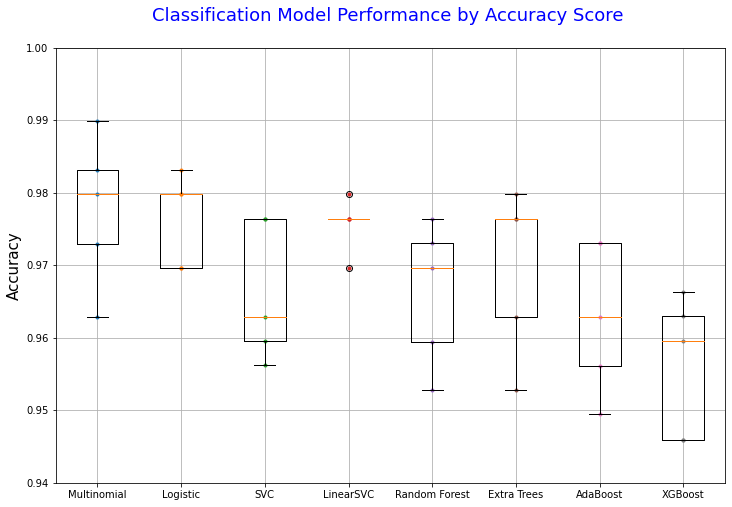

In [60]:
plt.figure(figsize = (12, 8))
plt.plot([1] * 5, multiNB_score, '.')
plt.plot([2] * 5, logit_score, '.')
plt.plot([3] * 5, svc_gr_score, '.')
plt.plot([4] * 5, lin_svc_gr, '.')
plt.plot([5] * 5, forest_gr_score, '.')
plt.plot([6] * 5, trees_gr_score, '.')
plt.plot([7] * 5, ada_clf_score, '.')
plt.plot([8] * 5, xgb_clf_score, '.')
plt.boxplot([multiNB_score, logit_score, svc_gr_score, lin_svc_gr, 
             forest_gr_score, trees_gr_score, ada_clf_score, xgb_clf_score],
           labels = ['Multinomial', 'Logistic', 'SVC', 'LinearSVC', 
                     'Random Forest', 'Extra Trees', 'AdaBoost', 'XGBoost'])
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.94, 1])
plt.grid(True)
plt.title('Classification Model Performance by Accuracy Score \n', fontsize = 18, color = 'b');

Biểu đồ trên đánh giá độ chính xác trên 5 fold kiểm định chéo trên tập huấn luyện.  Nhìn chung, các bộ phân loại mà ta sử dụng hoạt động khá tốt trên tập huấn luyện, độ chính xác >= 96%. Có thể thấy các bộ phân loại đơn lẻ hoạt động tốt hơn một chút so với các bộ phân loại kết hợp.


Việc chọn ra một thuật toán phân loại tốt nhất cho tập huấn luyện trên có vẻ hơi khó khăn một chút, vì các chỉ số đánh giá một bộ phân loại mà ta quan tâm trong trường hợp này không hẳn chỉ dựa trên _accuracy score_. Việc quan tâm đến _precision, recall, f1-score_ trên từng lớp sẽ cho cái nhìn tổng quát hơn.

Một cách tiếp cận cho trường hợp này là kết hợp các bộ phân loại với nhau thành một bộ phân loại biểu quyết. Điều này có vẻ khả thi vì trên cùng một bộ dữ liệu, ta đã huấn luyện 8 bộ phân loại độc lập khác nhau, điều này làm tăng khả năng các bộ phân loại này mắc phải những lỗi rất khác nhau. Việc kết hợp các bộ phân loại này thành một bộ phân loại ___ensemble___ có thể cải thiện độ chính xác và các chỉ số đánh giá khác.

Ta sẽ xây dựng một bộ phân loại biểu quyết với các mô hình dự đoán phía trên kèm theo các siêu tham số đã được tinh chỉnh của chúng. Để rút ngắn thời gian huấn luyện và tăng hiệu quả cho bộ phân loại biểu quyết, ta sẽ loại ra bộ phân loại nào có độ chính xác trên bất kỳ fold kiểm định chéo nào dưới 95%: `XGBoost` bị loại.


Bắt đầu với `Voting Classifier` trong lớp _ensemble_ của Sklearn:

In [61]:
from sklearn.ensemble import VotingClassifier

multiNB = MultinomialNB()
logit_clf = LogisticRegression(multi_class = 'ovr', random_state = 42)
svc = SVC(kernel = 'linear', C=1, gamma=0.001, probability = True, random_state = 42)
lin_svc = LinearSVC(loss = 'hinge', random_state = 42)
forest_clf = RandomForestClassifier(n_estimators = 120, bootstrap = False, random_state = 42)
trees_clf = ExtraTreesClassifier(n_estimators = 300, random_state = 42)
ada_clf = AdaBoostClassifier(RandomForestClassifier(n_estimators = 120, bootstrap = False), 
                             learning_rate = 0.5, n_estimators = 50, random_state = 42)

named_estimators = [('multiNB', multiNB),
                    ('logit_clf', logit_clf),
                    ('svc', svc),
                    ('lin_svc', lin_svc),
                    ('forest_clf', forest_clf),
                    ('trees_clf', trees_clf),
                    ('ada_clf', ada_clf)]

voting_clf = VotingClassifier(named_estimators, n_jobs=-1)
t1 = time.time()
voting_clf.fit(X_train_cv, y_train)
t2 = time.time()

print('Voting Classifier training took {:.2f}s.'.format(t2 - t1))

Voting Classifier training took 7.73s.


In [62]:
voting_clf.score(X_train_cv, y_train)

1.0

In [63]:
t1 = time.time()
voting_clf_score = cross_val_score(voting_clf, X_train_cv, y_train, cv=5)
t2 = time.time()

print('Voting Score: {}'.format(voting_clf_score.mean()))
print('Voting Classifier cross-validation took {:.2f}s.'.format(t2 - t1))

Voting Score: 0.981122031122031
Voting Classifier cross-validation took 29.97s.


Trung bình điểm số đánh giá trên 5 fold cao hơn hẳn so với bất kỳ bộ phân loại nào trước đó.

Ta sẽ xem mô hình hoạt động ra sao trên tập kiểm tra:

In [64]:
fc.eval_clf_testset(voting_clf, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.965

* Confusion Matrix of Test: 
[[93  0  1  0  2]
 [ 1 54  1  0  0]
 [ 2  1 63  0  1]
 [ 0  0  0 77  0]
 [ 3  0  1  0 71]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.94      0.97      0.95        96
entertainment       0.98      0.96      0.97        56
     politics       0.95      0.94      0.95        67
        sport       1.00      1.00      1.00        77
         tech       0.96      0.95      0.95        75

     accuracy                           0.96       371
    macro avg       0.97      0.96      0.97       371
 weighted avg       0.97      0.96      0.96       371



Độ chính xác trên tập kiểm tra khá ổn.

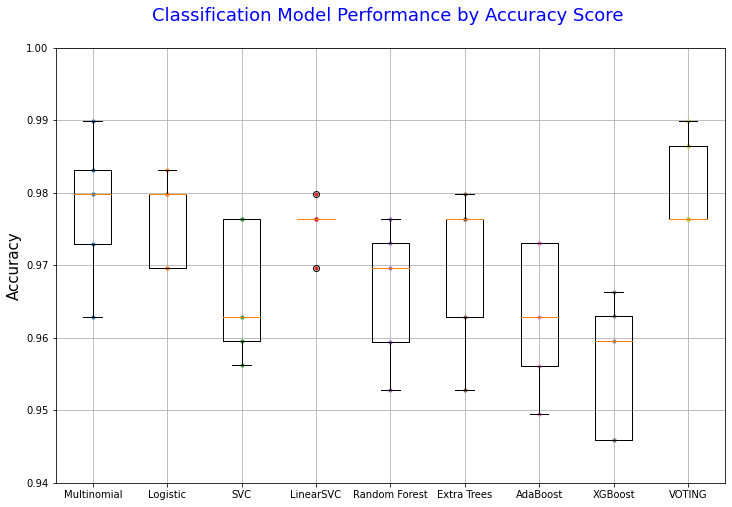

In [65]:
plt.figure(figsize = (12, 8))
plt.plot([1] * 5, multiNB_score, '.')
plt.plot([2] * 5, logit_score, '.')
plt.plot([3] * 5, svc_gr_score, '.')
plt.plot([4] * 5, lin_svc_gr, '.')
plt.plot([5] * 5, forest_gr_score, '.')
plt.plot([6] * 5, trees_gr_score, '.')
plt.plot([7] * 5, ada_clf_score, '.')
plt.plot([8] * 5, xgb_clf_score, '.')
plt.plot([9] * 5, voting_clf_score, '.')
plt.boxplot([multiNB_score, logit_score, svc_gr_score, lin_svc_gr, 
             forest_gr_score, trees_gr_score, ada_clf_score, xgb_clf_score, voting_clf_score],
           labels = ['Multinomial', 'Logistic', 'SVC', 'LinearSVC', 
                     'Random Forest', 'Extra Trees', 'AdaBoost', 'XGBoost', 'VOTING'])
plt.ylabel('Accuracy', fontsize = 15)
plt.ylim([0.94, 1])
plt.grid(True)
plt.title('Classification Model Performance by Accuracy Score \n', fontsize = 18, color = 'b');

Biểu đồ trên cho thấy bộ phân loại biểu quyết có độ chính xác trên kiểm định chéo cao hơn và ít biến động hơn so với các bộ phân loại khác.

Bộ phân loại biểu quyết có thể là mô hình phân loại khá ổn cho đến thời điểm này.

Bộ phân loại biểu quyết mà ta đang sử dụng dựa trên biểu quyết cứng _(hard voting)_. Ta sẽ thay đổi thành bộ biểu quyết mềm _(soft voting)_ với hy vọng độ chính xác sẽ cải thiện hơn:

- _Soft voting_ thường đạt chất lượng cao hơn vì sử dụng phương thức ước tính xác suất của từng lớp, đồng thời, các biểu quyết có độ tin cậy cao  sẽ được gán trọng số lớn hơn.
- Các bộ phân loại ta đã sử dụng mặc định đều có phương thức `predict_proba`, ngoại trừ `SVC` và `LinearSVC`. Đối với `SVC`, ta sẽ chỉnh tham số `probability = True` để có phương thức ước tính xác suất các lớp, đánh đổi bằng thời gian huấn luyện lâu hơn.
- Đối với `LinearSVC`, thuật toán này không có phương thức `predict_proba`, ta sẽ xem xét loại ra khỏi bộ phân loại biểu quyết vì hai lý do:
    1. `LinearSVC` không có phương thức ước tính xác suất như đã nói ở trên, đồng thời hiệu suất của `LinearSVC` gần như tương tự `SVC`.
    2. Việc giữ lại `SVC` thay vì `LinearSVC` sẽ khiến thời gian huấn luyện của bộ phân loại biểu quyết chậm đi một chút. Tuy nhiên, `SVC` lại phù hợp với các bộ dữ liệu vừa và nhỏ, đồng thời mở rộng tốt với _sparse matrix_ / _sparse features_ , khá phù hợp với bộ dữ liệu trong bài toán này.

In [66]:
named_estimators1 = [('multiNB', multiNB),
                    ('logit_clf', logit_clf),
                    ('svc', svc),
                    ('forest_clf', forest_clf),
                    ('trees_clf', trees_clf),
                    ('ada_clf', ada_clf)]

voting_modified = VotingClassifier(named_estimators1, n_jobs=-1)
t1 = time.time()
voting_modified.fit(X_train_cv, y_train)
t2 = time.time()

print('Voting Modified training took {:.2f}s.'.format(t2 - t1))

Voting Modified training took 8.31s.


Mô hình biểu quyết này vẫn là ___hard voting___ , ta sẽ so sánh với ___soft voting___ :

In [67]:
t1 = time.time()
hard_score = cross_val_score(voting_modified, X_train_cv, y_train)
t2 = time.time()
print('Hard Voting score: {:.3f}'.format(hard_score.mean()))
print('Hard Voting time: {}'.format(t2 - t1))

Hard Voting score: 0.976
Hard Voting time: 28.924309015274048


In [68]:
fc.eval_clf_testset(voting_modified, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.965

* Confusion Matrix of Test: 
[[94  0  0  0  2]
 [ 1 54  1  0  0]
 [ 3  1 62  0  1]
 [ 0  0  0 77  0]
 [ 3  0  1  0 71]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.93      0.98      0.95        96
entertainment       0.98      0.96      0.97        56
     politics       0.97      0.93      0.95        67
        sport       1.00      1.00      1.00        77
         tech       0.96      0.95      0.95        75

     accuracy                           0.96       371
    macro avg       0.97      0.96      0.97       371
 weighted avg       0.97      0.96      0.96       371



Bây giờ ta sẽ đổi thành bộ phân loại biểu quyết ___soft voting___ :

In [69]:
voting_modified.voting = 'soft'

In [70]:
t1 = time.time()
soft_score = cross_val_score(voting_modified, X_train_cv, y_train)
t2 = time.time()

print('Voting Soft score: {:.3f}'.format(soft_score.mean()))
print('Voting Soft time: {}'.format(t2 - t1))

Voting Soft score: 0.982
Voting Soft time: 30.120269060134888


In [71]:
fc.eval_clf_testset(voting_modified, X_test_cv, y_test)

----- CLASSIFICATION MODEL PREFOMANCE IN TEST SET-----
* R-squared model of Test: 0.9596

* Confusion Matrix of Test: 
[[91  1  2  0  2]
 [ 0 55  1  0  0]
 [ 2  1 63  0  1]
 [ 1  0  0 76  0]
 [ 3  0  1  0 71]]

* Classification Report of Test: 
               precision    recall  f1-score   support

     business       0.94      0.95      0.94        96
entertainment       0.96      0.98      0.97        56
     politics       0.94      0.94      0.94        67
        sport       1.00      0.99      0.99        77
         tech       0.96      0.95      0.95        75

     accuracy                           0.96       371
    macro avg       0.96      0.96      0.96       371
 weighted avg       0.96      0.96      0.96       371



Kiểm định chéo với ___soft voting___ cho kết quả cao hơn so với ___hard voting___ . Ta sẽ dùng bộ phân loại biểu quyết với phương thức `soft voting` để lưu model và đánh giá trên dữ liệu mới.

Ta sẽ lưu mô hình phân loại này trong một `Pipeline` bao gồm `CountVectorizer` để xử lý dữ liệu văn bản và `Bộ phân loại biểu quyết - Voting Modified` ta đã chọn phía trên.

In [72]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([('cv', cv),
                          ('voting_clf', voting_modified)])

Hàm lưu mô hình đã được viết trong thư viện __Lib__.

In [73]:
fc.save_model(full_pipeline, 'Text_Classification_VuTranHoaiHan.pkl')